# Experimentation noteboo

## 1. From Bragg peaks to Gausian approximations

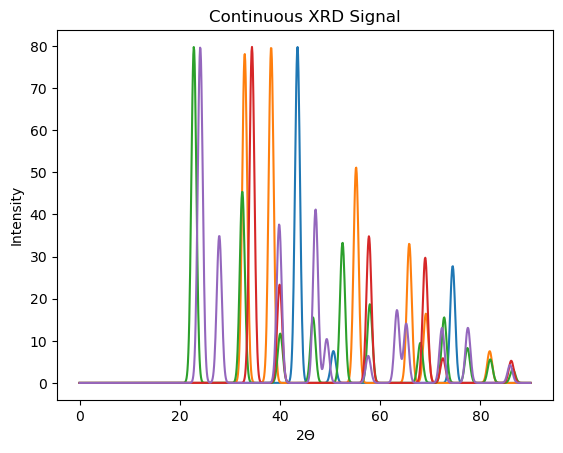

In [47]:
import numpy as np
from scipy.stats import norm
from pymatgen.core import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from multiprocessing import Pool
from glob import glob

def gaussian_signal_from_cif(args):
    cif, std, xrange = args
    
    xrd_calculator = XRDCalculator()
    structure = Structure.from_file(cif)
    diffraction_pattern = xrd_calculator.get_pattern(structure)
   
    signal = np.zeros_like(xrange)
    for pos, inten in zip(diffraction_pattern.x, diffraction_pattern.y):
        signal += inten * norm.pdf(xrange, pos, std)
    return signal

def generate_signals_for_structure(cifs, std, xrange):

    args = [(cif, std, xrange) for cif in cifs]

    with Pool(processes=5) as pool:
        signals = np.array(list(pool.imap(gaussian_signal_from_cif, args)))
    
    return signals

if __name__ == '__main__':
    # Example usage
    cifs = glob('CHILI-3K_raw_cifs/*.cif')[:5]

    # Define standard deviation for the Gaussian peaks
    std_dev = 0.5

    # Define the range of x-values (2-theta angles) for the signal
    x_range = np.linspace(0, 90, 1000)

    # Generate the continuous signals
    continuous_signals = generate_signals_for_structure(cifs, std_dev, x_range)

    # Plotting the result (optional)
    import matplotlib.pyplot as plt

    for signal in continuous_signals:
        plt.plot(x_range, signal)
        
    plt.xlabel('2$\Theta$')
    plt.ylabel('Intensity')
    plt.title('Continuous XRD Signal')
    plt.show()


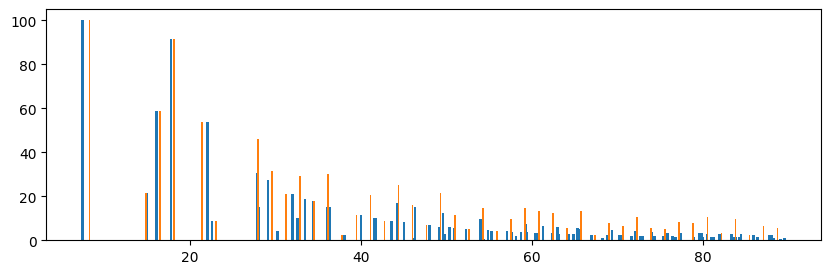

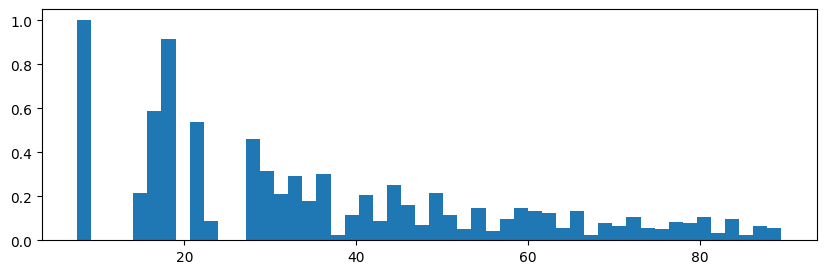

In [53]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.structure import Structure
from pymatgen.io.cif import CifParser
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
from math import asin, cos, degrees, pi, radians, sin

def tth_to_q(tth, wl):
    return (4 * np.pi / wl) * np.sin(np.radians(tth) / 2)

# Make cif string
with open('cifs_v1_test/MP_mp-1006815.cif', 'r') as f:
    cif_lines = f.readlines()
cif = ''.join(cif_lines)

# Get structure
try:
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]
except:
    parser = CifParser.from_str(cif)
    structure = parser.parse_structures(primitive=True)[0]

# Get Diffraction
calc = XRDCalculator()
out = calc.get_pattern(structure)

# Make figure
fig, ax = plt.subplots(figsize=(10,3))

ax.bar(out.x, out.y, width=0.3)
#plt.show()

# Make figure histogram
n_bins = 50
counts, bin_edges = np.histogram(out.x, bins=n_bins, weights=out.y)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.bar(bin_centers, counts, width=0.2)
plt.show()

# Make figure histogram with full width
fig, ax = plt.subplots(figsize=(10,3))
ax.hist(out.x, weights=out.y/100, bins=n_bins)
plt.show()

## 2. Convertion from TTH to Q

In [1]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.core.structure import Structure
from pymatgen.io.cif import CifParser
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
from math import asin, cos, degrees, pi, radians, sin

In [2]:
def tth_to_q(tth, wl):
    return (4 * np.pi / wl) * np.sin(np.radians(tth) / 2)

97


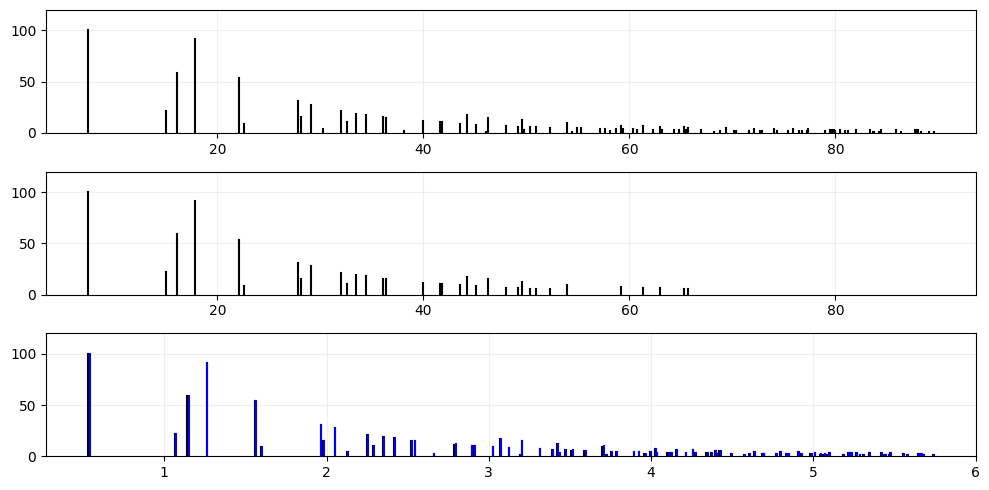

34


In [8]:
# Make cif string
with open('cifs_v1_test/MP_mp-1006815.cif', 'r') as f:
    cif_lines = f.readlines()
cif = ''.join(cif_lines)

# Get structure
try:
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]
except:
    parser = CifParser.from_str(cif)
    structure = parser.parse_structures(primitive=True)[0]

# Get Diffraction
calc = XRDCalculator()
out = calc.get_pattern(structure)

# Digitize
n_bins = 1000
y_bin_edges = np.linspace(0, 100, n_bins-1)
y_to_id = lambda y: np.digitize(y, y_bin_edges, right=True)

x_bin_edges = np.linspace(0, 10, n_bins-1)
#print(x_bin_edges)
x_to_id = lambda x: np.digitize(x, x_bin_edges, right=True)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,5))

ax1.plot([out.x,out.x], [np.zeros_like(out.y),out.y], c='k', label='TTH')
ax3.plot([tth_to_q(out.x, calc.wavelength),tth_to_q(out.x, calc.wavelength)], 
         [np.zeros_like(out.y),out.y], c='k', label='ORIGINAL Q')
ax3.plot([x_bin_edges[x_to_id(tth_to_q(out.x, calc.wavelength))],
          x_bin_edges[x_to_id(tth_to_q(out.x, calc.wavelength))]], 
         [np.zeros_like(out.y),y_bin_edges[y_to_id(out.y)]], c='b', label='DIGITIZED Q')
    
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0,120)
    ax.grid(alpha=0.2)

ax2.set_xlim(ax1.get_xlim())

print(len(out.x))

x = out.x[out.y > 5.0]
y = out.y[out.y > 5.0]

ax2.plot([x, x], [np.zeros_like(y), y], c='k')

fig.tight_layout()
plt.show()
print(len(x))

In [5]:
# Get cifs:
def calc_diff(path):
    with open(path, 'r') as f:
        cif_lines = f.readlines()
    cif = ''.join(cif_lines)

    # Get structure
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]

    # Get Diffraction
    calc = XRDCalculator()
    out = calc.get_pattern(structure, two_theta_range=(0,180), scaled=True)
    
    return out

In [7]:
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.io.cif import CifParser, CifBlock
from pymatgen.core.operations import SymmOp
import re

def return_operators(cif_str, space_group_symbol):
    space_group = SpaceGroup(space_group_symbol)
    symmetry_ops = space_group.symmetry_ops

    loops = []
    data = {}
    symmops = []
    for op in symmetry_ops:
        v = op.translation_vector
        symmops.append(SymmOp.from_rotation_and_translation(op.rotation_matrix, v))

    ops = [op.as_xyz_string() for op in symmops]
    data["_symmetry_equiv_pos_site_id"] = [f"{i}" for i in range(1, len(ops) + 1)]
    data["_symmetry_equiv_pos_as_xyz"] = ops

    loops.append(["_symmetry_equiv_pos_site_id", "_symmetry_equiv_pos_as_xyz"])

    symm_block = str(CifBlock(data, loops, "")).replace("data_\n", "")

    #pattern = r"(loop_\n_symmetry_equiv_pos_site_id\n_symmetry_equiv_pos_as_xyz\n\s*1\s*'x, y, z'\n)"
    pattern = r"(loop_\n\s*_symmetry_equiv_pos_site_id\s*_symmetry_equiv_pos_as_xyz\n\s*1\s*'x, y, z')"

    cif_str_updated = re.sub(pattern, symm_block, cif_str)

    return cif_str_updated

In [8]:
from tqdm.auto import tqdm
from crystallm import (
    extract_space_group_symbol,
    replace_symmetry_operators,
    remove_atom_props_block,
)

  0%|          | 0/2 [00:00<?, ?it/s]

4695
4623


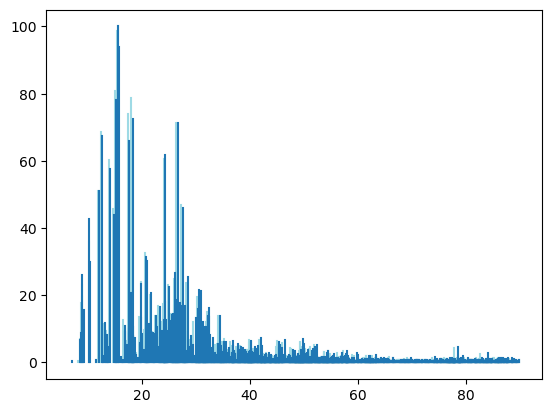

In [24]:
fig, ax = plt.subplots()

paths = sorted(glob('cifs_v1_test/*'))
paths = ['cifs_v1_test/MP_mp-1196206.cif', 'EntryWithCollCode252548.cif']
colors = cmap(np.linspace(0, 1, len(paths)))

for c, path in tqdm(zip(colors, paths), total=len(paths)):
    
    # Make cif string
    with open(path, 'r') as f:
        cif_lines = f.readlines()
    cif = ''.join(cif_lines)
    
    try:
        space_group = extract_space_group_symbol(cif)
        if space_group is not None and space_group != 'P 1':
            cif = return_operators(cif, space_group)
        
        cif = remove_atom_props_block(cif)
    except:
        pass

    # Get structure
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]

    # Get Diffraction
    calc = XRDCalculator()
    out = calc.get_pattern(structure, two_theta_range=(0,90), scaled=True)
    print(len(out.x))
#     if len(out.x) > 4000:
#         print(path)
    ax.plot([out.x,out.x], [np.zeros_like(out.y),out.y], c=c)
#         break

plt.show()

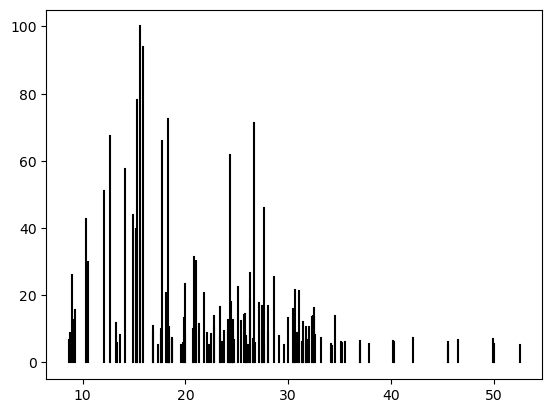

125


In [34]:
x = out.x[out.y > 5]
y = out.y[out.y > 5]

fig, ax = plt.subplots()

ax.plot([x, x], [np.zeros_like(y), y], c='k')
plt.show()
print(len(x))

In [34]:
import torch
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np

In [35]:
def get_losses(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    losses_train = torch.stack(checkpoint['train_losses'])
    losses_val = torch.stack(checkpoint['val_losses'])
    epochs = torch.tensor(checkpoint['epoch_losses'])
    fname = '/'.join(ckpt_path.split('/')[:-1])
    print(fname, checkpoint['config']['prefix_size'])
    return losses_train, losses_val, epochs, fname

In [36]:
def plot_curves(paths, start=0, end=None, ylog=True, xlog=False, xmin=0, xmax=500, offset = 0.02):
    fig, ax = plt.subplots(figsize=(10,5), dpi=150)
    
    if end is None:
        end = xmax
        
    ax.set_xlim(xmin, xmax)
    
    text_positions = []
    
    ax.set(xlabel='Epoch', ylabel='CE-Loss')
    if ylog:
        ax.set_yscale('log')
    if xlog:
        ax.set_xscale('log')
    ax.grid(alpha=0.2)
   

    for path in paths:
        losses_train, losses_val, epochs, fname = get_losses(path)
        p = ax.plot(epochs[start:end], losses_train[start:end], label=fname)
        ax.plot(epochs[start:end], losses_val[start:end], c=p[0].get_color(), ls='--')
        
        # Find the minimum value in losses_val and its corresponding epoch
        val_line_min = epochs[np.argmin(losses_val)].item()
        min_loss_val = torch.min(losses_val).item()
        
        # Plot the dotted line
        ax.plot([val_line_min, ax.get_xlim()[1]], [min_loss_val, min_loss_val],
                c=p[0].get_color(), ls=':', alpha=1.0)
        
        # Adjust text position if overlapping
        text_x = ax.get_xlim()[1]
        text_y = min_loss_val
        
        vert_align = 'bottom'
        for pos in text_positions:
            if abs(pos[1] - text_y) < offset:  # Check for overlap
                vert_align = 'top'
            else:
                vert_align = 'bottom'
        
        # Add text at the end of the dotted line
        ax.text(text_x, text_y, f'{min_loss_val:.4f}', 
                verticalalignment=vert_align, horizontalalignment='right', color=p[0].get_color(),
                fontsize=10)
        
        text_positions.append((text_x, text_y))
        
    ax.legend(fontsize=8, ncol=4, loc='upper right')
    fig.tight_layout()
    plt.show()

debug_v1_train_10k 100
debug_v1_train_10k_encoded 100
debug_fixed_length_prefix 100


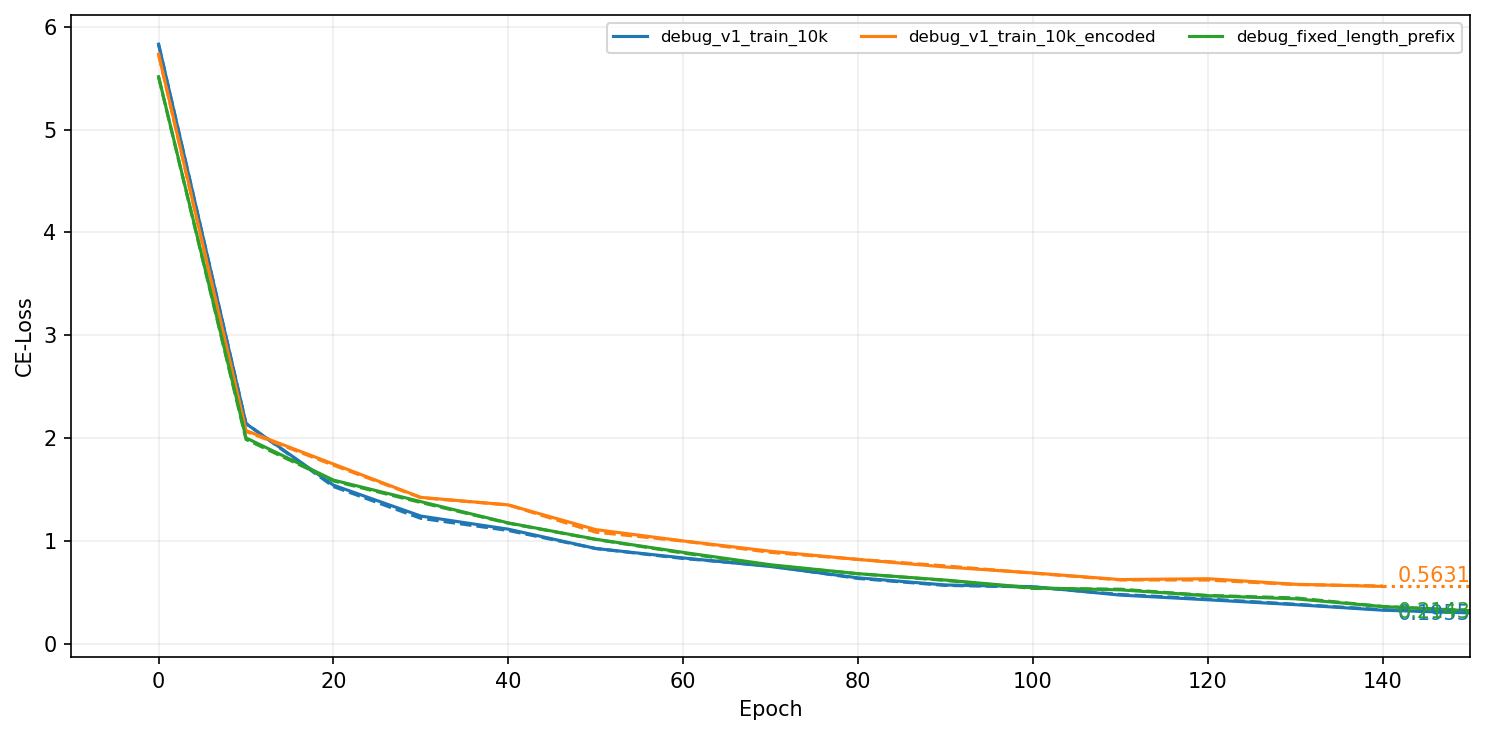

In [187]:
plot_curves(
    [
        'debug_v1_train_10k/ckpt.pt',
        'debug_v1_train_10k_encoded/ckpt.pt',
        'debug_fixed_length_prefix/ckpt.pt'
#         'debug_v1_train_10k_interleaved/ckpt.pt',
    ],
    end = None,
    xmax = 150,
    xmin = -10,
    ylog = False,
    offset = 0.3
)

XRD_VS_EMPTY/delete_test 100
XRD_VS_EMPTY/delete_test_empty 100


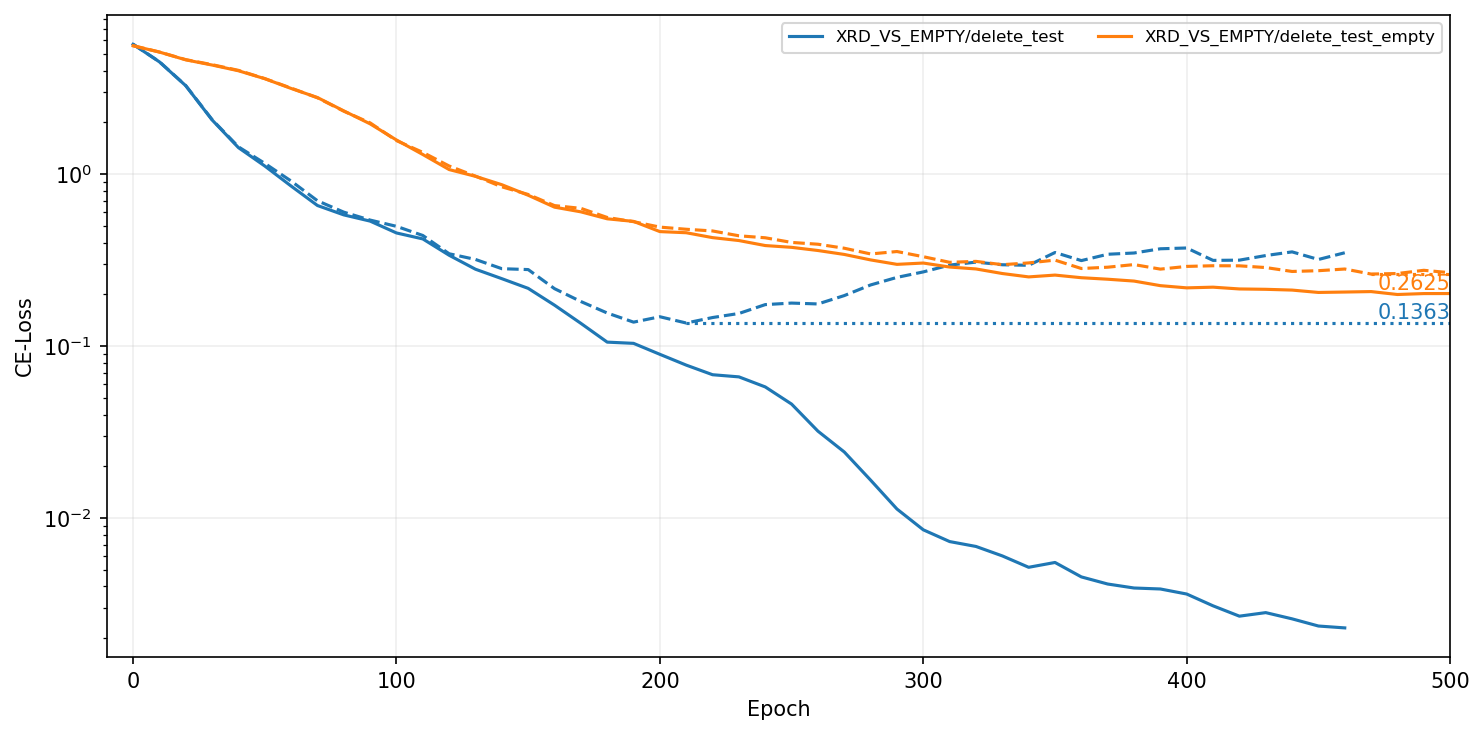

In [188]:
plot_curves(
    [
        'XRD_VS_EMPTY/delete_test/ckpt.pt',
        'XRD_VS_EMPTY/delete_test_empty/ckpt.pt',
#         'debug_v1_test/ckpt.pt',
    ],
    end = None,
    xmax = 500,
    xmin = -10,
    ylog = True,
    offset = 0.3
)

debug_v1_train_10k 100
v1_100k 100


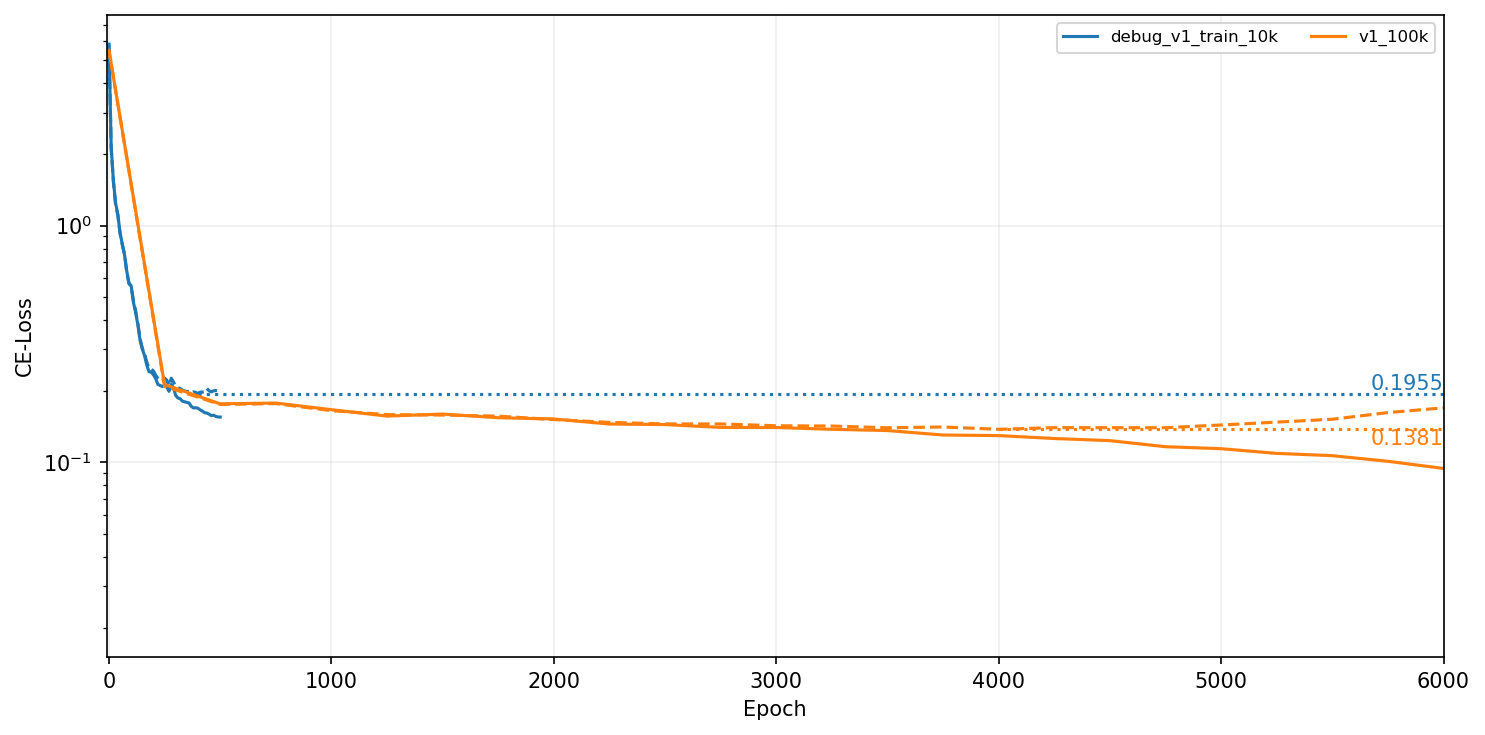

In [228]:
plot_curves(
    [
#         'XRD_VS_EMPTY/delete_test/ckpt.pt',
#         'XRD_VS_EMPTY/delete_test_empty/ckpt.pt',
#         'debug_v1_test/ckpt.pt',
        'debug_v1_train_10k/ckpt.pt',
#         'debug_v1_train_10k_encoded/ckpt.pt',
#         'debug_v1_train_10k_interleaved/ckpt.pt',
#         'debug_v1_train_10k_2d/ckpt.pt',
        'v1_100k/ckpt.pt',
#         'debug_fixed_length_prefix/ckpt.pt',
#         'debug_concat/ckpt.pt',
#         'debug_concat_fixed/ckpt.pt',
#         'debug_concat_fixed_big/ckpt.pt',
#         'v1_100k_lora/ckpt.pt'
    ],
    end = None,
    xmax = 6000,
    xmin = -10,
    ylog = True,
    offset = 0.3
)

debug_concat_fixed 100
debug_v1_train_10k 100


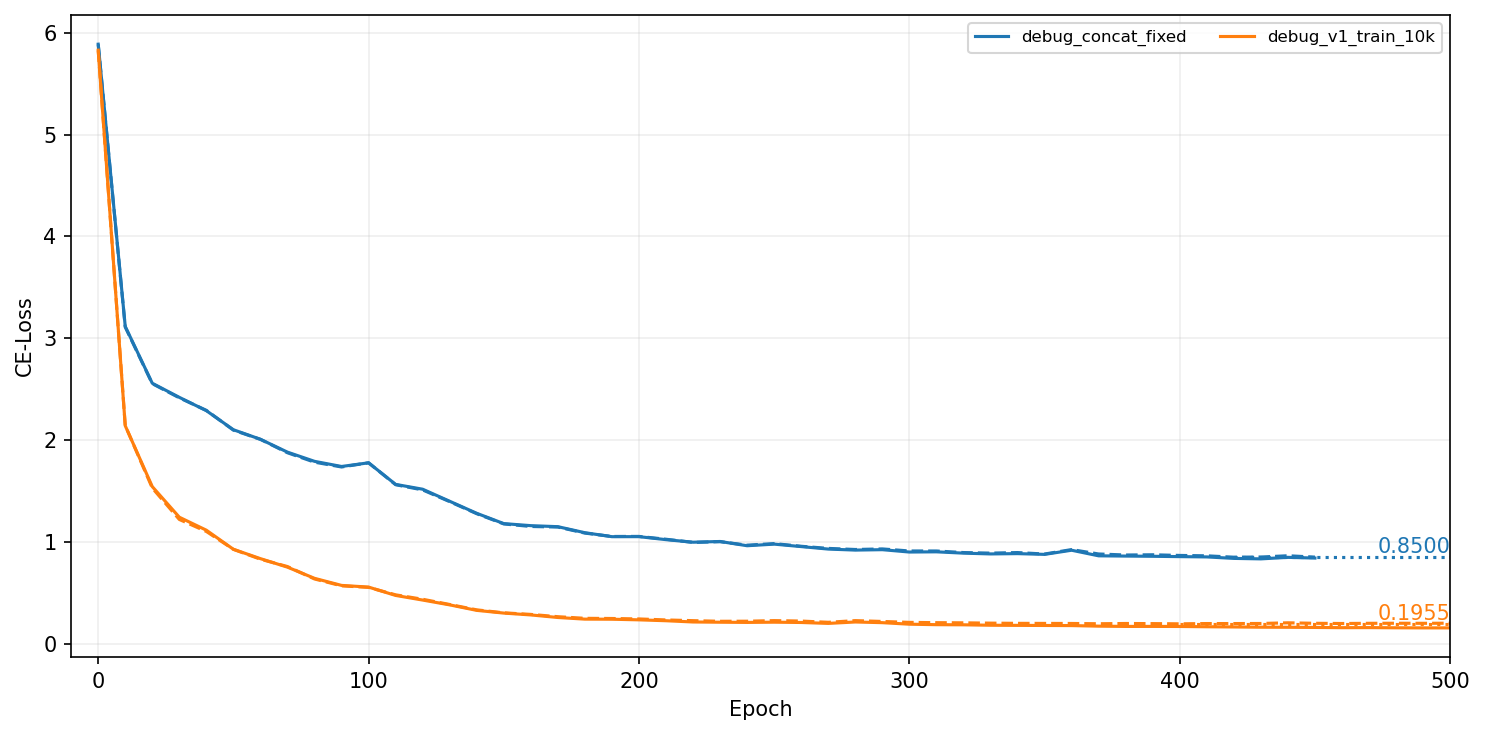

In [215]:
plot_curves(
    [

        'debug_concat_fixed/ckpt.pt',
        'debug_v1_train_10k/ckpt.pt',
    ],
    end = None,
    xmax = 500,
    xmin = -10,
    ylog = False,
    offset = 0.3
)

v1_10k_finetuning_nolora 100
debug_concat_fixed_finetune 100
debug_concat_fixed_finetune_smaller_lr 100


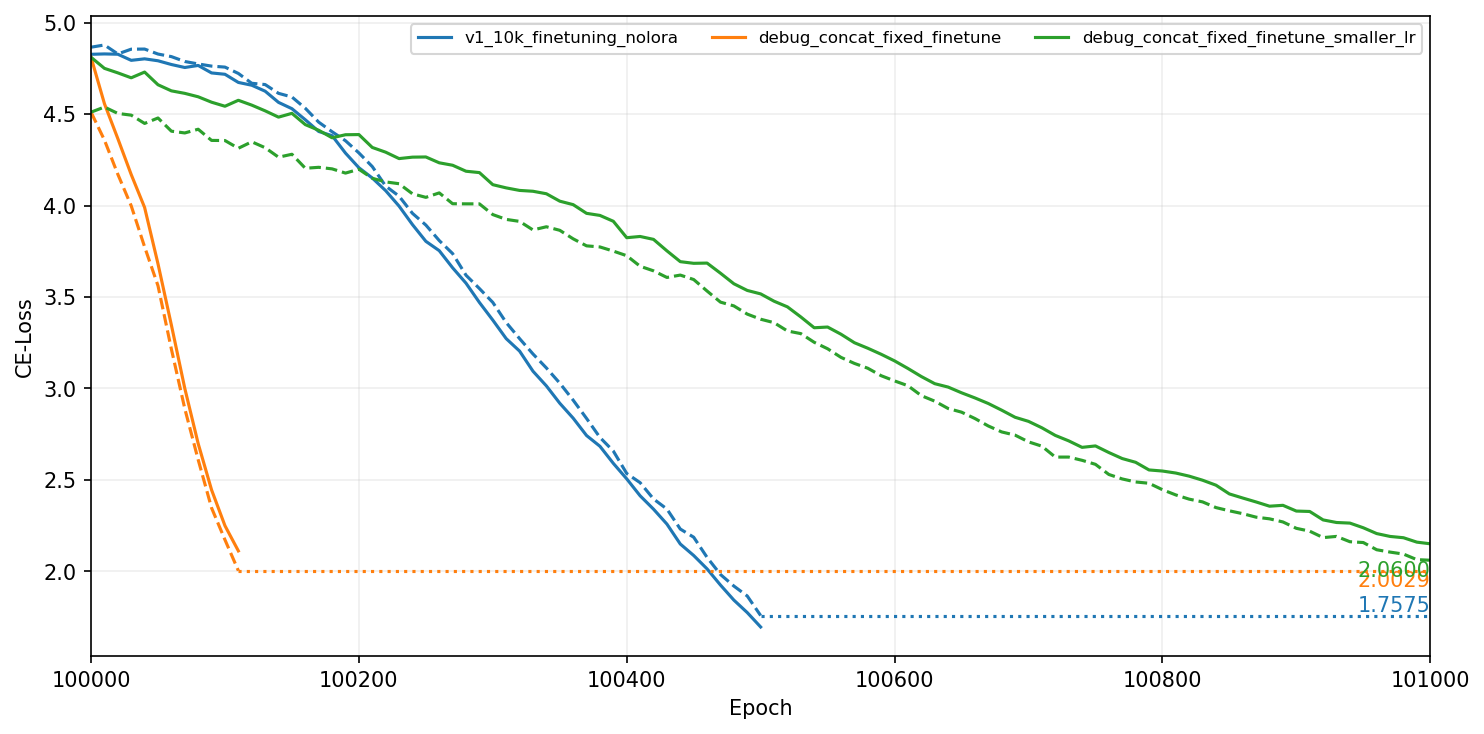

In [232]:
plot_curves(
    [
        'v1_10k_finetuning_nolora/ckpt.pt',
        'debug_concat_fixed_finetune/ckpt.pt',
        'debug_concat_fixed_finetune_smaller_lr/ckpt.pt'
    ],
    end = None,
    xmax = 101_000,
    xmin = 100_000,
    ylog = False,
    offset = 0.3
)

### Evaluation of XRD

In [531]:
from pymatgen.io.cif import CifParser
from pymatgen.analysis.diffraction.xrd import XRDCalculator

# Get random XRD pattern
out_patterns = []

for path in ['cifs_v1_test/MP_mp-1006815.cif', 'cifs_v1_test/MP_mp-1019379.cif']:
    
    with open(path, 'r') as f:
        cif_lines = f.readlines()
    cif = ''.join(cif_lines)

    # Get structure
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]

    # Get Diffraction
    calc = XRDCalculator()
    pattern = calc.get_pattern(structure)
    
    # Store the pattern in the list
    out_patterns.append(pattern)

# Assign to out_1 and out_2
out_1, out_2 = out_patterns

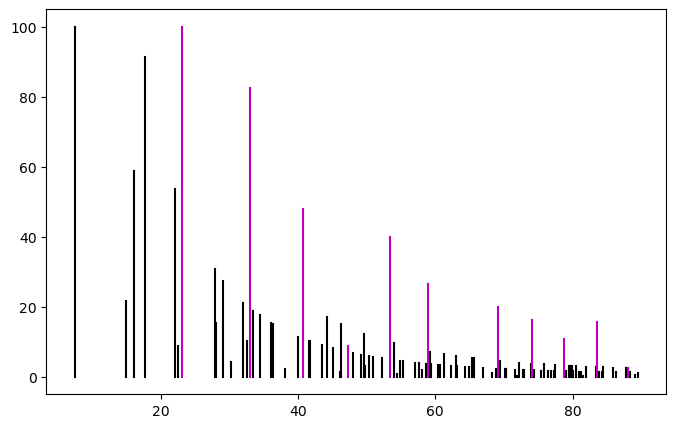

In [536]:
# Plot XRD patterns
fig, ax = plt.subplots(figsize=(8,5))

ax.plot([out_1.x, out_1.x], [np.zeros_like(out_1.y), out_1.y], c='k')
ax.plot([out_2.x, out_2.x], [np.zeros_like(out_2.y), out_2.y], c='m')

plt.show()

RMSD between the two XRD patterns: 0.31286377426257334


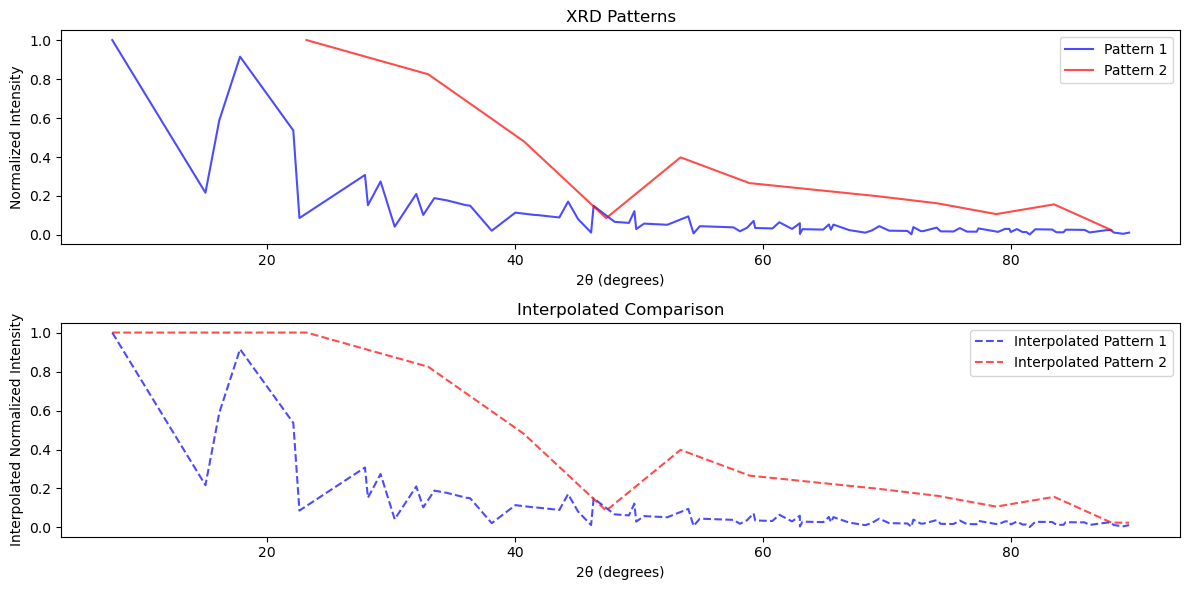

In [539]:
import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np

def extract_peaks(pattern):
    return pattern.x, pattern.y

def normalize_intensities(intensities):
    return intensities / np.max(intensities)

def calculate_rmsd(peaks1, peaks2):
    pos1, intens1 = peaks1
    pos2, intens2 = peaks2
    
    # Interpolate intensities to a common set of positions
    common_positions = np.union1d(pos1, pos2)
    intens1_interpolated = np.interp(common_positions, pos1, intens1)
    intens2_interpolated = np.interp(common_positions, pos2, intens2)
    
    # Calculate RMSD
    rmsd = np.sqrt(np.mean((intens1_interpolated - intens2_interpolated)**2))
    return rmsd, common_positions, intens1_interpolated, intens2_interpolated

# Get random XRD pattern
out_patterns = []

for path in ['cifs_v1_test/MP_mp-1006815.cif', 'cifs_v1_test/MP_mp-1019379.cif']:
    
    with open(path, 'r') as f:
        cif_lines = f.readlines()
    cif = ''.join(cif_lines)

    # Get structure
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]

    # Get Diffraction
    calc = XRDCalculator()
    pattern = calc.get_pattern(structure)
    
    # Store the pattern in the list
    out_patterns.append(pattern)

# Assign to out_1 and out_2
out_1, out_2 = out_patterns

# Extract peaks
peaks1 = extract_peaks(out_1)
peaks2 = extract_peaks(out_2)

# Normalize intensities
peaks1 = (peaks1[0], normalize_intensities(peaks1[1]))
peaks2 = (peaks2[0], normalize_intensities(peaks2[1]))

# Calculate RMSD
rmsd, common_positions, intens1_interpolated, intens2_interpolated = calculate_rmsd(peaks1, peaks2)

print(f"RMSD between the two XRD patterns: {rmsd}")

# Plotting the XRD patterns and their comparison
plt.figure(figsize=(12, 6))

# Original patterns
plt.subplot(2, 1, 1)
plt.plot(peaks1[0], peaks1[1], label='Pattern 1', color='blue', alpha=0.7)
plt.plot(peaks2[0], peaks2[1], label='Pattern 2', color='red', alpha=0.7)
plt.title('XRD Patterns')
plt.xlabel('2θ (degrees)')
plt.ylabel('Normalized Intensity')
plt.legend()

# Interpolated comparison
plt.subplot(2, 1, 2)
plt.plot(common_positions, intens1_interpolated, label='Interpolated Pattern 1', color='blue', linestyle='dashed', alpha=0.7)
plt.plot(common_positions, intens2_interpolated, label='Interpolated Pattern 2', color='red', linestyle='dashed', alpha=0.7)
plt.title('Interpolated Comparison')
plt.xlabel('2θ (degrees)')
plt.ylabel('Interpolated Normalized Intensity')
plt.legend()

plt.tight_layout()
plt.show()


RMSD between the two XRD patterns: 0.08838851910041606


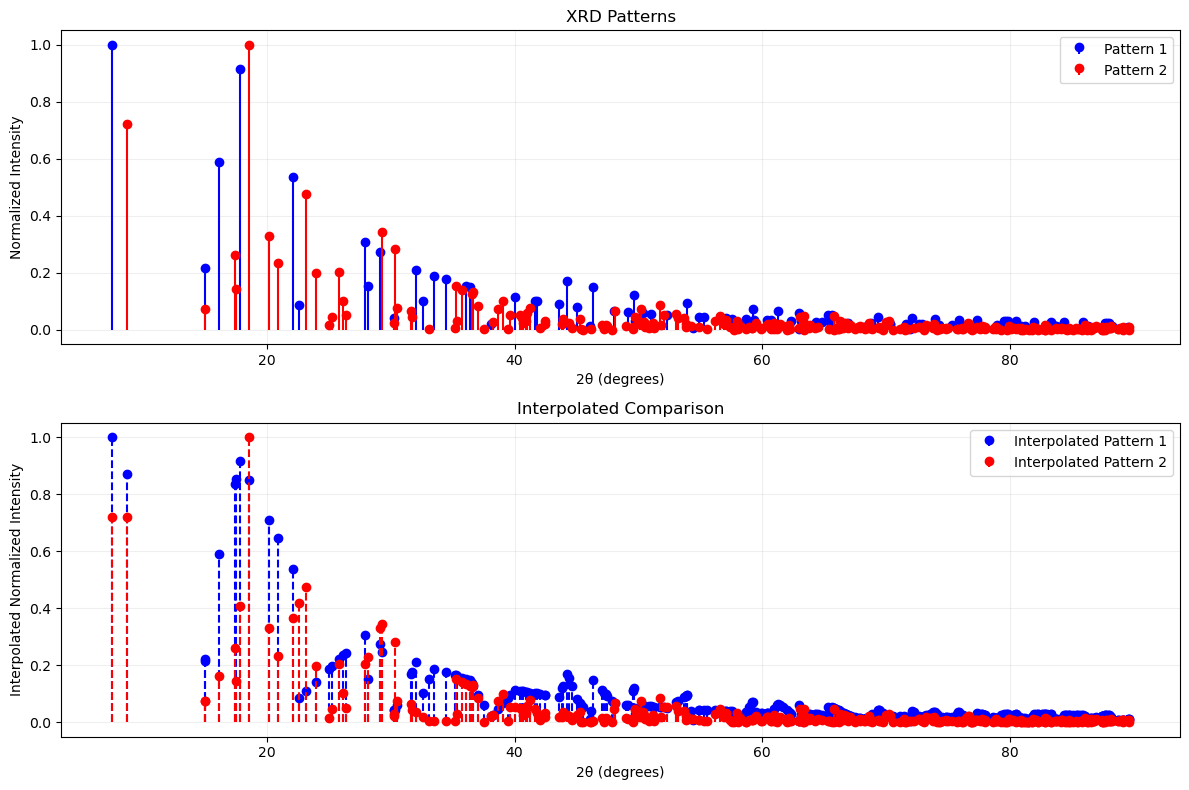

In [550]:
import matplotlib.pyplot as plt
from pymatgen.io.cif import CifParser
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import numpy as np

def extract_peaks(pattern):
    return pattern.x, pattern.y

def normalize_intensities(intensities):
    return intensities / np.max(intensities)

def calculate_rmsd(peaks1, peaks2):
    pos1, intens1 = peaks1
    pos2, intens2 = peaks2
    
    # Interpolate intensities to a common set of positions
    common_positions = np.union1d(pos1, pos2)
    intens1_interpolated = np.interp(common_positions, pos1, intens1)
    intens2_interpolated = np.interp(common_positions, pos2, intens2)
    
    # Calculate RMSD
    rmsd = np.sqrt(np.mean((intens1_interpolated - intens2_interpolated)**2))
    return rmsd, common_positions, intens1_interpolated, intens2_interpolated

# Get random XRD pattern
out_patterns = []

for path in ['cifs_v1_test/MP_mp-1006815.cif', 'cifs_v1_test/MP_mp-759826.cif']:
    
    with open(path, 'r') as f:
        cif_lines = f.readlines()
    cif = ''.join(cif_lines)

    # Get structure
    parser = CifParser.from_string(cif)
    structure = parser.get_structures()[0]

    # Get Diffraction
    calc = XRDCalculator(symprec=0.1)
    pattern = calc.get_pattern(structure)
    
    # Store the pattern in the list
    out_patterns.append(pattern)

# Assign to out_1 and out_2
out_1, out_2 = out_patterns

# Extract peaks
peaks1 = extract_peaks(out_1)
peaks2 = extract_peaks(out_2)

# Normalize intensities
peaks1 = (peaks1[0], normalize_intensities(peaks1[1]))
peaks2 = (peaks2[0], normalize_intensities(peaks2[1]))

# Calculate RMSD
rmsd, common_positions, intens1_interpolated, intens2_interpolated = calculate_rmsd(peaks1, peaks2)

print(f"RMSD between the two XRD patterns: {rmsd}")

# Plotting the XRD patterns and their comparison
plt.figure(figsize=(12, 8))

# Original patterns
plt.subplot(2, 1, 1)
plt.stem(peaks1[0], peaks1[1], linefmt='b-', markerfmt='bo', basefmt=' ', label='Pattern 1')
plt.stem(peaks2[0], peaks2[1], linefmt='r-', markerfmt='ro', basefmt=' ', label='Pattern 2')
plt.title('XRD Patterns')
plt.xlabel('2θ (degrees)')
plt.ylabel('Normalized Intensity')
plt.legend()

plt.grid(alpha=0.2)

# Interpolated comparison
plt.subplot(2, 1, 2)
plt.stem(common_positions, intens1_interpolated, linefmt='b--', markerfmt='bo', basefmt=' ', label='Interpolated Pattern 1')
plt.stem(common_positions, intens2_interpolated, linefmt='r--', markerfmt='ro', basefmt=' ', label='Interpolated Pattern 2')
plt.title('Interpolated Comparison')
plt.xlabel('2θ (degrees)')
plt.ylabel('Interpolated Normalized Intensity')
plt.legend()

plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


Hausdorff distance (Bragg peaks): 1.0


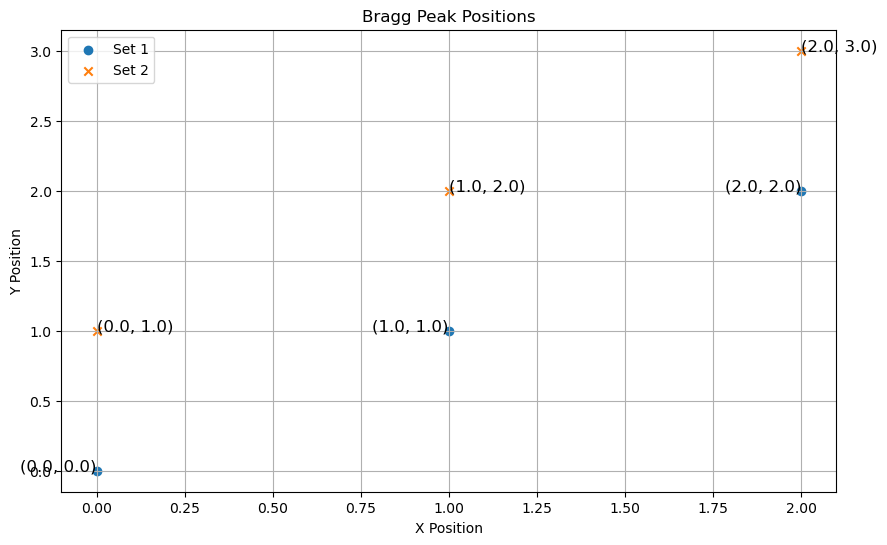

In [11]:
import torch
import matplotlib.pyplot as plt

def hausdorff_distance(set1, set2):
    """
    Compute the Hausdorff distance between two sets of points.
    
    Parameters:
    set1 (torch.Tensor): Tensor of shape (N, 2) representing N points in 2D.
    set2 (torch.Tensor): Tensor of shape (M, 2) representing M points in 2D.
    
    Returns:
    torch.Tensor: The Hausdorff distance.
    """
    pairwise_distances = torch.cdist(set1, set2)
    forward_hausdorff = torch.max(torch.min(pairwise_distances, dim=1)[0])
    backward_hausdorff = torch.max(torch.min(pairwise_distances, dim=0)[0])
    hausdorff_distance = torch.max(forward_hausdorff, backward_hausdorff)
    
    return hausdorff_distance

def plot_bragg_peaks(set1, set2):
    plt.figure(figsize=(10, 6))
    
    # Plot set1
    plt.scatter(set1[:, 0].numpy(), set1[:, 1].numpy(), label='Set 1', marker='o')
    for i in range(set1.shape[0]):
        plt.text(set1[i, 0].item(), set1[i, 1].item(), f'({set1[i, 0].item()}, {set1[i, 1].item()})', fontsize=12, ha='right')

    # Plot set2
    plt.scatter(set2[:, 0].numpy(), set2[:, 1].numpy(), label='Set 2', marker='x')
    for i in range(set2.shape[0]):
        plt.text(set2[i, 0].item(), set2[i, 1].item(), f'({set2[i, 0].item()}, {set2[i, 1].item()})', fontsize=12, ha='left')
    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Bragg Peak Positions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
set1 = torch.tensor([[0.0, 0.0], [1.0, 1.0], [2.0, 2.0]])
set2 = torch.tensor([[0.0, 1.0], [1.0, 2.0], [2.0, 3.0]])

distance = hausdorff_distance(set1, set2)
print(f"Hausdorff distance (Bragg peaks): {distance.item()}")

plot_bragg_peaks(set1, set2)


In [5]:
import re
import numpy as np

data = """0.86,100.0
1.8,10.57
1.86,5.89
2.05,13.86
2.11,13.68
2.44,40.27
3.07,14.08
3.07,9.09
3.08,18.96
3.29,11.47
3.3,16.62
3.31,5.89
3.34,8.69
3.41,5.66
3.61,6.04
4.69,5.55"""

# Define the regex pattern to match each pair of numbers
pattern = re.compile(r'(\d+\.\d+),(\d+\.\d+)')

# Find all matches in the string
matches = pattern.findall(data)

# Separate the matches into two lists
list1 = [float(match[0]) for match in matches]
list2 = [float(match[1]) for match in matches]

# Display the results
print("List 1:", list1)
print("List 2:", list2)


np.array([[float(match[0]),float(match[1])] for match in matches]).T

List 1: [0.86, 1.8, 1.86, 2.05, 2.11, 2.44, 3.07, 3.07, 3.08, 3.29, 3.3, 3.31, 3.34, 3.41, 3.61, 4.69]
List 2: [100.0, 10.57, 5.89, 13.86, 13.68, 40.27, 14.08, 9.09, 18.96, 11.47, 16.62, 5.89, 8.69, 5.66, 6.04, 5.55]


array([[  0.86,   1.8 ,   1.86,   2.05,   2.11,   2.44,   3.07,   3.07,
          3.08,   3.29,   3.3 ,   3.31,   3.34,   3.41,   3.61,   4.69],
       [100.  ,  10.57,   5.89,  13.86,  13.68,  40.27,  14.08,   9.09,
         18.96,  11.47,  16.62,   5.89,   8.69,   5.66,   6.04,   5.55]])